In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
pd.set_option('max_columns', 30)

%matplotlib inline

In [95]:
def load_train_data(data_name):
    data = pd.read_csv('data/train_' + data_name + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['TTL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [127]:
def load_test_data(data_name):
    data = pd.read_csv('data/test_' + data_name + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    RUL = pd.read_csv('data/RUL_' + data_name + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')    
    return data
    

In [218]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [479]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10)) + np.sum(np.exp(d[d < 0] / 13))

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)


In [224]:
train_fd3 = load_train_data('FD003')
test_fd3 = load_test_data('FD003')

In [307]:
test_sample_rows = test_fd3.groupby(['unit']).agg({'cycle' : max})
test_sample_rows = test_sample_rows.reset_index()
test_sample_rows = test_sample_rows.merge(test_fd3, how = 'left', left_on = ['unit', 'cycle'],
                                                                 right_on = ['unit', 'cycle'])

test_sample_rows['total_cycles'] = test_sample_rows.apply(lambda r: int(r['cycle'] + r['RUL']), axis = 1)

In [426]:
y = train_fd3['TTL'].values
#X = train_fd3[['cycle'] + list(range(2, 26))]
X = train_fd3[list(range(2, 26))]

#X_pred = test_sample_rows[['cycle'] + list(range(2, 26))]
X_pred = test_sample_rows[list(range(2, 26))]

X = X.apply(normalize, axis = 0)
X.dropna(how = 'all', axis = 1, inplace = True)

X_pred = X_pred.apply(normalize, axis = 0)
X_pred.dropna(how = 'all', axis = 1, inplace = True)

del X[20]

X = X.as_matrix()
X_pred = X_pred.as_matrix()

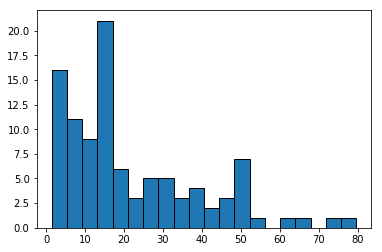

In [482]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.show()

In [480]:
compute_score(y_real, y_pred) / 100, 5518 / 218

(26.91024150193125, 25.31192660550459)

In [481]:
MSE(y_real, y_pred)

2.805778240236724

In [476]:
np.median(np.abs(y_real - y_pred))

15.194466114044189

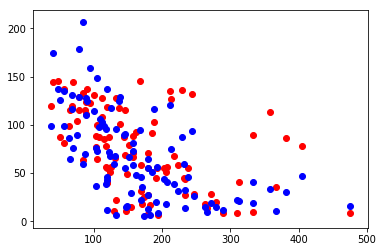

In [475]:
plt.scatter(test_sample_rows['cycle'], y_real, color = 'red')
plt.scatter(test_sample_rows['cycle'], y_pred, color = 'blue')
#plt.ylim([0, 200])
plt.show()

In [472]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [19])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Jan\\AppData\\Local\\Temp\\tmp073phnjm', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Jan\AppData\Local\Temp\tmp073phnjm\model.ckpt.
INFO:tensorflow:loss = 2.77438e+06, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Jan\AppData\Local\Temp\tmp073phnjm\model.ckpt.
INFO:tensorflow:Loss for final step: 278902.0.


In [473]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Restoring parameters from C:\Users\Jan\AppData\Local\Temp\tmp073phnjm\model.ckpt-100


In [474]:
compute_score(y_real, y_pred) / 100

26.91024150193125